# OpenAI Responses API V2 Client - Complete Guide

This notebook demonstrates the `OpenAIResponsesV2Client` which implements the new OpenAI Responses API with rich `UnifiedResponse` objects.

## Key Features

- **Stateful Conversations**: Maintain conversation context via `previous_response_id`
- **Built-in Tools**: Web search, image generation, apply_patch
- **Rich Content Blocks**: TextContent, ReasoningContent, CitationContent, ImageContent, ToolCallContent
- **Multimodal Support**: Send and receive images
- **Structured Output**: Pydantic models and JSON schema support
- **Cost Tracking**: Token and image generation cost tracking
- **Agent Integration**: Works with AG2 agents for single, two-agent, and group chat

## Requirements

AG2 requires `Python>=3.9`. Install the required packages:

In [ ]:
%pip install "ag2[openai]" -q

## Setup

Set your OpenAI API key as an environment variable or pass it directly to the client.

In [ ]:
import os

# Set your API key (or use environment variable OPENAI_API_KEY)
# os.environ["OPENAI_API_KEY"] = "sk-..."

---

# 1. Basic Usage

The `OpenAIResponsesV2Client` returns rich `UnifiedResponse` objects with typed content blocks.

In [ ]:
from autogen.llm_clients.openai_resposnes_v2_client import OpenAIResponsesV2Client

# Create the V2 client
client = OpenAIResponsesV2Client()

# Make a simple request
response = client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "how are you? tell me about yourself? and what is a machine? in one line"}]
})

# Access the response
print(f"Response ID: {response.id}")
print(f"Model: {response.model}")
print(f"Content: {response.messages[0].get_text()}")

Response ID: resp_0e58793f72f33bbe0069807fee3f9481959bba844296dddda6
Model: gpt-4.1-2025-04-14
Content: Thanks for asking—I'm doing well! I am ChatGPT, an artificial intelligence (AI) language model created by OpenAI. My purpose is to assist you by answering questions, offering explanations, helping with tasks like writing or problem-solving, and engaging in conversation on a wide variety of topics. I don't have feelings or consciousness, but I'm designed to communicate as naturally and helpfully as possible.

**A little about myself:**
- I was trained on vast amounts of text from books, articles, web pages, and more.
- I can answer questions, summarize information, help with creative writing, and even code.
- My knowledge is up-to-date as of June 2024.

**What is a machine?**

A **machine** is a device or collection of devices that uses mechanical power and has several parts, each with a specific function. Machines are designed to perform a particular task or a set of tasks. They can 

## Understanding UnifiedResponse Structure

The `UnifiedResponse` contains rich, typed content blocks:

In [4]:
from autogen.llm_clients.models.content_blocks import (
    TextContent,
    ReasoningContent,
    CitationContent,
    ImageContent,
    ToolCallContent,
    GenericContent,
)

# Inspect the response structure
print(f"Number of messages: {len(response.messages)}")
print(f"Usage: {response.usage}")
print(f"Cost: ${response.cost:.6f}")

# Iterate through content blocks
for msg in response.messages:
    print(f"\nRole: {msg.role}")
    for block in msg.content:
        if isinstance(block, TextContent):
            print(f"  Text: {block.text[:100]}..." if len(block.text) > 100 else f"  Text: {block.text}")
        elif isinstance(block, ReasoningContent):
            print(f"  Reasoning: {block.text[:100]}...")

Number of messages: 1
Usage: {'prompt_tokens': 22, 'completion_tokens': 364, 'total_tokens': 386, 'token_cost': 0.002956, 'image_cost': 0.0}
Cost: $0.002956

Role: assistant
  Text: Thanks for asking—I'm doing well! I am ChatGPT, an artificial intelligence (AI) language model creat...


---

# 2. Stateful Conversations

The Responses API is **stateful** - it maintains conversation context server-side using `previous_response_id`.

In [3]:
# Create a new client for stateful conversation
stateful_client = OpenAIResponsesV2Client()

# First message
response1 = stateful_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "My name is Alice. Remember this."}]
})
print(f"Response 1: {response1.messages[0].get_text()}")
print(f"Response ID: {response1.id}")

Response 1: Got it, Alice! I'll remember your name for our conversation. How can I help you today?
Response ID: resp_08889b1405d262700069807ff9fcc48193b7a1a56cb6c99752


In [5]:
# Second message - the client automatically tracks state
response2 = stateful_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What is my name?"}]
})
print(f"Response 2: {response2.messages[0].get_text()}")
print(f"\nThe model remembered the context from the previous turn!")

Response 2: Your name is Alice! How can I assist you further?

The model remembered the context from the previous turn!


In [6]:
# Reset conversation state to start fresh
stateful_client.reset_conversation()

response3 = stateful_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What is my name?"}]
})
print(f"After reset: {response3.messages[0].get_text()}")
print("\nThe model no longer has context from previous conversation.")

After reset: You haven't provided your name yet, so I don't know it. If you'd like to share your name or a nickname, feel free to do so!

The model no longer has context from previous conversation.


## Manual State Control

You can also manually control the conversation state:

In [7]:
# Get current state
current_state = stateful_client._get_previous_response_id()
print(f"Current state: {current_state}")

# Or pass previous_response_id directly in params

# Get a fresh response ID
response_a = client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "Hello, my name is Alice"}]
})

response_a_id = client._get_previous_response_id()

response_b = client.create({
        "model": "gpt-4.1",
        "messages": [{"role": "user", "content": "Hello, my name is Hatter"}]
})

response_b_id = client._get_previous_response_id()

# Use the fresh ID immediately
client._set_previous_response_id(response_a.id)
response_a1 = client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What's my name?"}],
    # "previous_response_id": response_a.id  # Use the real, fresh ID
})

response_a1.messages[0].get_text()

client._set_previous_response_id(response_b.id)
response_b1 = client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What's my name?"}],
    # "previous_response_id": response_b.id  # Use the real, fresh ID
})
response_a1_id = client._get_previous_response_id()
response_b1_id = client._get_previous_response_id()

print("response_a1_id", response_a1_id)
print("response_b1_id", response_b1_id)


Current state: resp_038a4724cdf5ec2400698080249ea8819c8963951284153344
response_a1_id resp_0e58793f72f33bbe0069808031f350819588c7a1a33ab0c3e3
response_b1_id resp_0e58793f72f33bbe0069808031f350819588c7a1a33ab0c3e3


---

# 3. Multimodal Support

Send images in your messages using various formats.

In [13]:
# Create a multimodal message with an image URL
multimodal_message = OpenAIResponsesV2Client.create_multimodal_message(
    text="What do you see in this image?",
    images=["https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400"],
    role="user"
)

print("Multimodal message structure:")
print(multimodal_message)

Multimodal message structure:
{'role': 'user', 'content': [{'type': 'input_text', 'text': 'What do you see in this image?'}, {'type': 'input_image', 'image_url': 'https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400', 'detail': 'auto'}]}


In [14]:
# Send multimodal request
mm_client = OpenAIResponsesV2Client()

response = mm_client.create({
    "model": "gpt-4.1",  # Use a vision-capable model
    "messages": [multimodal_message]
})

print(f"Image description: {response.messages[0].get_text()}")

Image description: This image shows a happy dog with brown and white fur. The dog appears to be outdoors, possibly at a beach or near water, as the background is blurry but suggests sand and blue water. The dog is looking toward the camera with its mouth open, as if it is smiling. One of its ears is perked up while the other is flopping down.


---

# 4. Built-in Tools

The Responses API provides built-in tools that don't require function definitions.

## 4.1 Web Search

In [16]:
# Enable web search
search_client = OpenAIResponsesV2Client()

response = search_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What are the latest news about AI?"}],
    "built_in_tools": ["web_search"]
})

print(f"Response: {response.messages[0].get_text()[:500]}...")

Response: Here are some recent developments in the field of artificial intelligence:

**National Archives Integrates AI into New Exhibit**

The U.S. National Archives has launched "The American Story," a $40 million permanent exhibit that utilizes AI and machine learning to enhance access to over two million historical records. Opened in November 2025 ahead of the United States' 250th anniversary, the exhibit allows visitors to explore personalized content by selecting topics and record types of interest....


In [17]:
# Extract citations from the response
citations = OpenAIResponsesV2Client.get_citations(response)

print(f"\nFound {len(citations)} citations:")
for citation in citations[:5]:  # Show first 5
    print(f"  - {citation.title}: {citation.url}")


Found 12 citations:
  - National Archives bets on AI to modernize museum: https://www.axios.com/2026/01/29/national-archives-ai-semiquincentennial?utm_source=openai
  - International AI Safety Report: https://en.wikipedia.org/wiki/International_AI_Safety_Report?utm_source=openai
  - AI use in American newspapers is widespread, uneven, and rarely disclosed: https://arxiv.org/abs/2510.18774?utm_source=openai
  - Google DeepMind: https://en.wikipedia.org/wiki/Google_DeepMind?utm_source=openai
  - Google DeepMind: https://en.wikipedia.org/wiki/Google_DeepMind?utm_source=openai


## 4.2 Image Generation

Generated 1 image(s)


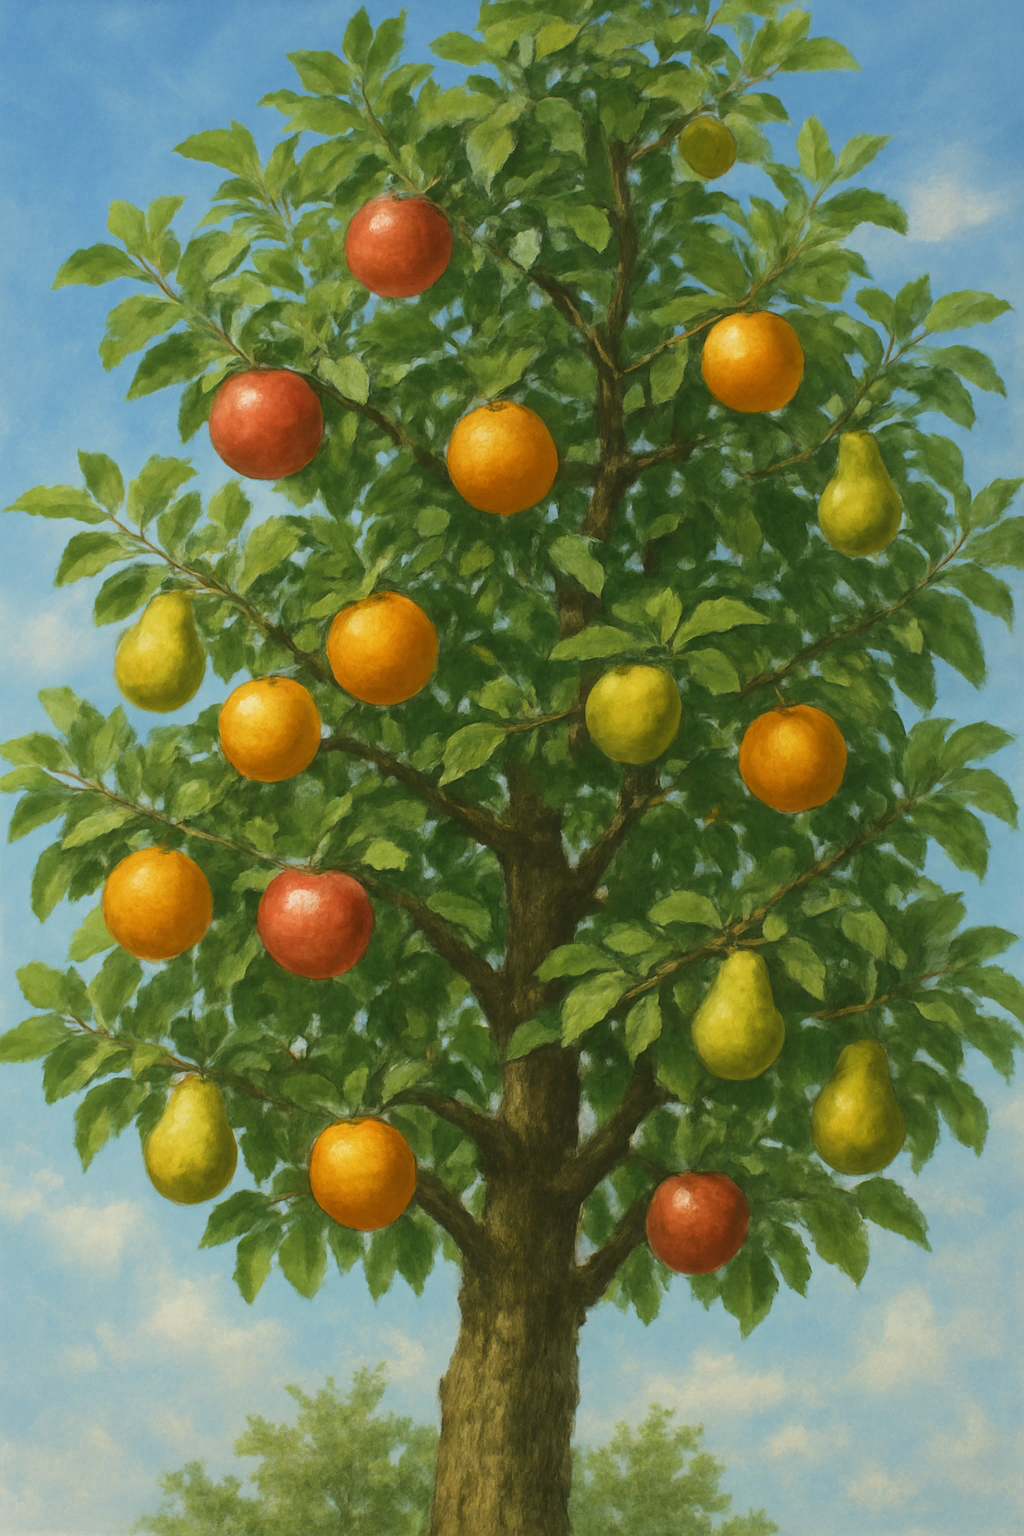

In [25]:
from IPython.display import Image, display
import base64
# Enable image generation
image_client = OpenAIResponsesV2Client()

# # Configure image output parameters
# image_client.set_image_output_params(
#     quality="high",
#     size="1024x1024",
#     output_format="png"
# )

response = image_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "Generate an image of a tree with fruits"}],
    "built_in_tools": ["image_generation"]
})

# Extract generated images
images = OpenAIResponsesV2Client.get_generated_images(response)
print(f"Generated {len(images)} image(s)")

if images:
    # Get the data URI
    data_uri = images[0].data_uri
    
    # Extract base64 data (remove the "data:image/png;base64," prefix)
    if data_uri and data_uri.startswith("data:"):
        # Split on comma to get base64 data
        base64_data = data_uri.split(",", 1)[1]
        
        # Display the image
        display(Image(data=base64.b64decode(base64_data)))

In [26]:
# Check image generation costs
print(f"Image costs: ${image_client.get_image_costs():.4f}")
print(f"Total costs: ${image_client.get_total_costs():.4f}")

Image costs: $0.0630
Total costs: $0.0647


## 4.3 Structured Output

In [28]:
from pydantic import BaseModel

# Define a Pydantic model for structured output
class Person(BaseModel):
    name: str
    age: int
    occupation: str

# Request structured output
struct_client = OpenAIResponsesV2Client()

response = struct_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "Generate a fictional person's profile"}],
    "response_format": Person
})

# Get the parsed object
parsed = OpenAIResponsesV2Client.get_parsed_object(response)
if parsed:
    print(f"Name: {parsed.name}")
    print(f"Age: {parsed.age}")
    print(f"Occupation: {parsed.occupation}")

TypeError: Unable to automatically parse response format type {'type': 'json_schema', 'json_schema': {'schema': {'properties': {'name': {'title': 'Name', 'type': 'string'}, 'age': {'title': 'Age', 'type': 'integer'}, 'occupation': {'title': 'Occupation', 'type': 'string'}}, 'required': ['name', 'age', 'occupation'], 'title': 'Person', 'type': 'object', 'additionalProperties': False}, 'name': 'Person', 'strict': True}}

---

# 5. Cost Tracking

The V2 client tracks both token costs and image generation costs.

In [ ]:
cost_client = OpenAIResponsesV2Client()

# Make several requests
for i in range(3):
    response = cost_client.create({
        "model": "gpt-4.1",
        "messages": [{"role": "user", "content": f"Count to {i+1}"}]
    })
    
    # Per-request cost
    usage = OpenAIResponsesV2Client.get_usage(response)
    print(f"Request {i+1}: {usage['total_tokens']} tokens, ${usage['cost']:.6f}")

In [ ]:
# Get cumulative usage
cumulative = cost_client.get_cumulative_usage()
print(f"\nCumulative Usage:")
print(f"  Total prompt tokens: {cumulative['prompt_tokens']}")
print(f"  Total completion tokens: {cumulative['completion_tokens']}")
print(f"  Total tokens: {cumulative['total_tokens']}")
print(f"  Token cost: ${cumulative['token_cost']:.6f}")
print(f"  Image cost: ${cumulative['image_cost']:.6f}")
print(f"  Total cost: ${cumulative['total_cost']:.6f}")

In [ ]:
# Reset cost tracking
cost_client.reset_all_costs()
print(f"After reset: ${cost_client.get_total_costs():.6f}")

In [ ]:
# Set custom pricing for fine-tuned models
custom_client = OpenAIResponsesV2Client()
custom_client.set_custom_price(
    input_price_per_1k=0.003,
    output_price_per_1k=0.006
)

response = custom_client.create({
    "model": "ft:gpt-4.1:my-org:custom-model",
    "messages": [{"role": "user", "content": "Hello"}]
})

print(f"Cost with custom pricing: ${custom_client.cost(response):.6f}")

---

# 6. V1 Backward Compatibility

For code that expects ChatCompletion format, use `create_v1_compatible()`.

In [ ]:
v1_client = OpenAIResponsesV2Client()

# Get ChatCompletion-like response
response = v1_client.create_v1_compatible({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "Hello!"}]
})

# Access like standard ChatCompletion
print(f"Type: {type(response).__name__}")
print(f"Content: {response.choices[0].message.content}")
print(f"Tokens: {response.usage.total_tokens}")
print(f"Cost: ${response.cost:.6f}")

---

# 7. Agent Integration

The V2 client integrates with AG2 agents for conversational AI workflows.

## 7.1 Single Agent

In [ ]:
import autogen

# Configure LLM with Responses API
config_list = [
    {
        "model": "gpt-4.1",
        "api_type": "responses",  # Use Responses API
    }
]

llm_config = {"config_list": config_list}

# Create a single assistant agent
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config=llm_config,
    system_message="You are a helpful AI assistant."
)

# Create a user proxy agent
user_proxy = autogen.UserProxyAgent(
    name="user",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=1,
    code_execution_config=False,
)

# Start a conversation
user_proxy.initiate_chat(
    assistant,
    message="What is the capital of France?"
)

## 7.2 Two-Agent Chat

In [ ]:
# Create two specialized agents
researcher = autogen.AssistantAgent(
    name="researcher",
    llm_config=llm_config,
    system_message="""You are a research assistant. Your job is to:
    1. Analyze questions thoroughly
    2. Provide detailed, factual information
    3. Cite sources when possible"""
)

critic = autogen.AssistantAgent(
    name="critic",
    llm_config=llm_config,
    system_message="""You are a critical reviewer. Your job is to:
    1. Review the researcher's findings
    2. Point out any gaps or inaccuracies
    3. Suggest improvements
    Say 'TERMINATE' when the research is satisfactory."""
)

# Two-agent collaboration
researcher.initiate_chat(
    critic,
    message="Research the benefits and drawbacks of renewable energy sources.",
    max_turns=4
)

## 7.3 Group Chat

In [ ]:
# Create multiple specialized agents for group chat
planner = autogen.AssistantAgent(
    name="planner",
    llm_config=llm_config,
    system_message="""You are a project planner. Break down tasks into actionable steps.
    Focus on creating clear, organized plans."""
)

developer = autogen.AssistantAgent(
    name="developer",
    llm_config=llm_config,
    system_message="""You are a software developer. Implement solutions based on the plan.
    Write clean, well-documented code."""
)

reviewer = autogen.AssistantAgent(
    name="reviewer",
    llm_config=llm_config,
    system_message="""You are a code reviewer. Review implementations for:
    1. Correctness
    2. Best practices
    3. Potential improvements
    Say 'TERMINATE' when the solution is complete and reviewed."""
)

user_proxy_gc = autogen.UserProxyAgent(
    name="user",
    human_input_mode="NEVER",
    code_execution_config=False,
)

In [ ]:
# Create group chat
group_chat = autogen.GroupChat(
    agents=[user_proxy_gc, planner, developer, reviewer],
    messages=[],
    max_round=10
)

manager = autogen.GroupChatManager(
    groupchat=group_chat,
    llm_config=llm_config
)

# Start the group chat
user_proxy_gc.initiate_chat(
    manager,
    message="Create a Python function that calculates the Fibonacci sequence up to n terms."
)

---

# 8. Advanced: Custom Function Tools

Combine built-in tools with custom function tools.

In [ ]:
# Define custom tools
def get_weather(city: str) -> str:
    """Get the current weather for a city."""
    # Mock implementation
    return f"The weather in {city} is sunny, 72°F"

def calculate(expression: str) -> str:
    """Evaluate a mathematical expression."""
    try:
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"Error: {e}"

# Define tool schemas
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get current weather for a city",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {"type": "string", "description": "City name"}
                },
                "required": ["city"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "calculate",
            "description": "Evaluate a math expression",
            "parameters": {
                "type": "object",
                "properties": {
                    "expression": {"type": "string", "description": "Math expression"}
                },
                "required": ["expression"]
            }
        }
    }
]

print("Tools defined successfully!")

In [ ]:
# Use custom tools with the V2 client
tools_client = OpenAIResponsesV2Client()

response = tools_client.create({
    "model": "gpt-4.1",
    "messages": [{"role": "user", "content": "What's 25 * 4 + 10?"}],
    "tools": tools
})

# Check for tool calls
for msg in response.messages:
    for block in msg.content:
        if isinstance(block, ToolCallContent):
            print(f"Tool call: {block.name}({block.arguments})")
        elif isinstance(block, TextContent):
            print(f"Text: {block.text}")

---

# Summary

The `OpenAIResponsesV2Client` provides:

| Feature | Description |
|---------|-------------|
| **Stateful Conversations** | Automatic context tracking via `previous_response_id` |
| **Rich Content Blocks** | TextContent, ReasoningContent, CitationContent, ImageContent, ToolCallContent |
| **Built-in Tools** | Web search, image generation, apply_patch |
| **Multimodal Support** | Send and receive images |
| **Structured Output** | Pydantic models and JSON schemas |
| **Cost Tracking** | Token and image generation cost tracking |
| **V1 Compatibility** | `create_v1_compatible()` for ChatCompletion format |
| **Agent Integration** | Works with AG2 single, two-agent, and group chat |

For more information, see the [AG2 documentation](https://docs.ag2.ai).